# Single Catenary Line

## Setup

- We first install all necessary packages.

- We next import the packages using the following commands.

In [1]:
import numpy as np
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

## Define properties of the line

Keeping all variables in SI Units (kg, m, s) and force in Newton (N

The properties of the line are

1. W_pm = Mass per meter (kg/m). (Remains constant)
2. EA = Elastic stiffness of the line. (Remains constant)
3. L_tot = Total length of the line. (Remains constant)
4. L_susp = Length of the line that is suspended in the water. (Changes with loading)

Positioning of the line

- At anchor, (x,z) = (0,0)
- At fairlead (xEnd, zEnd)

Forces at the end points of the line

- At anchor (H, V) = (-H0, V0)
    - For this exercise we restrict V0 = 0. This implies that the a portion of the chain always remains on the groud.
- At fairlead (H,V) = (HEnd, VEnd)
    - This is the load applied on the catenary line.
    - Fairlead is the point at which the line is attached to the floating body.
    - VEnd is primarily due to the weight of the suspended portion of the chain itself.
- Note that HEnd = H0
    - This is assuming no drag load on the line.
 

Hence the unknowns in the system are

- L_susp
- HEnd (H0)
- VEnd
- xEnd
- zEnd

So we have 5 unknowns in the systems!

We now define the physical properties of the line.

In [2]:
g = 9.81 #m/s2
W_pm = 180 #kg/m
EA = 2201000000 #N
L_tot = 1200 #m

## Functions for solving the single line system 

We define a function `catenary_end_xz()` where

- Constants: W_pm, EA, L_Tot
- Input: V0, HEnd or H0, L_susp
- Output: xEnd, zEnd

This function hence returns the end position of the fairlead, given the horizontal force applied at the fairlead and the length of the suspended portion of the line.

In [3]:
def catenary_end_xz(W_pm, L_tot, EA, V0, H0, L_susp):
    
    W = W_pm*L_susp*g
        
    s = L_susp    
    z_t1 = 1 + (V0/H0)**2
    z_t2 = 1 + ((V0 - W*s/L_susp)/H0)**2
    z = W*s/EA * (s/2/L_susp - V0/W) - H0*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))            
    x_susp = H0*s/EA + H0*L_susp/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L_susp)/H0))
    x_bed = L_tot - L_susp
    x = x_bed + x_susp
        
    return x, z

We test the above function for a hypothetical line with

In [4]:
V0 = 0
HEnd = 106000 #N (=H0)
L_susp = 1000
xEnd, zEnd = catenary_end_xz(W_pm, L_tot, EA, V0, HEnd, L_susp)

print("Position of the fairlead are (xEnd, zEnd) = ", f"{xEnd:.5}", f"{zEnd:.5}" )

Position of the fairlead are (xEnd, zEnd) =  410.57 942.17


## Plotting the entire catenary line

We would like to see how this line actually looks. 
To do this we define the following function `plot_catenary_xz()` where

- Constants: W_pm, EA, L_Tot
- Input: V0, HEnd or H0, L_susp, ds
    - Here `ds` is the resolution at which the line is plotted. 
- Output: Plot of the catenary line

This function hence plot of the entire line, given the horizontal force applied at the fairlead and the length of the suspended portion of the line.

In [5]:
def plot_catenary_xz(W_pm, L_tot, EA, V0, H0, L_susp, ds):
        
    W = W_pm * L_susp * g
    
    # c_s = [0]
    # c_x = [L_tot - L_susp]
    # c_z = [0]
    # c_H = [H0]
    # c_V = [V0]
    
    c_s = [0, 0]    
    c_x = [0, L_tot - L_susp]
    c_z = [0, 0]
    c_H = [H0, H0]
    c_V = [V0, V0]
    
    Ns = math.floor(L_susp/ds)
    ds = L_susp/Ns
    for i in range(1,Ns+1):
        s = c_s[-1]+ds        
        z_t1 = 1 + (V0/H0)**2
        z_t2 = 1 + ((V0 - W*s/L_susp)/H0)**2
        z = W*s/EA * (s/2/L_susp-V0/W) - H0*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))        
        x_susp = H0*s/EA + H0*L_susp/W*(np.arcsinh(V0/H0) - np.arcsinh((V0 - W*s/L_susp)/H0))        
        V = V0 + W_pm*s*g
        x = L_tot - L_susp + x_susp
        
        c_s.append(s)        
        c_x.append( x )
        c_z.append( z )        
        c_V.append( V )
        
    print(c_s[-1], c_x[-1], c_z[-1], c_V[-1])
        
    return c_s, c_x, c_z, c_V

Testing the above function for a hypothetical line.

1000.0000000001588 410.56944729884583 942.1718345122282 1765800.0000002806


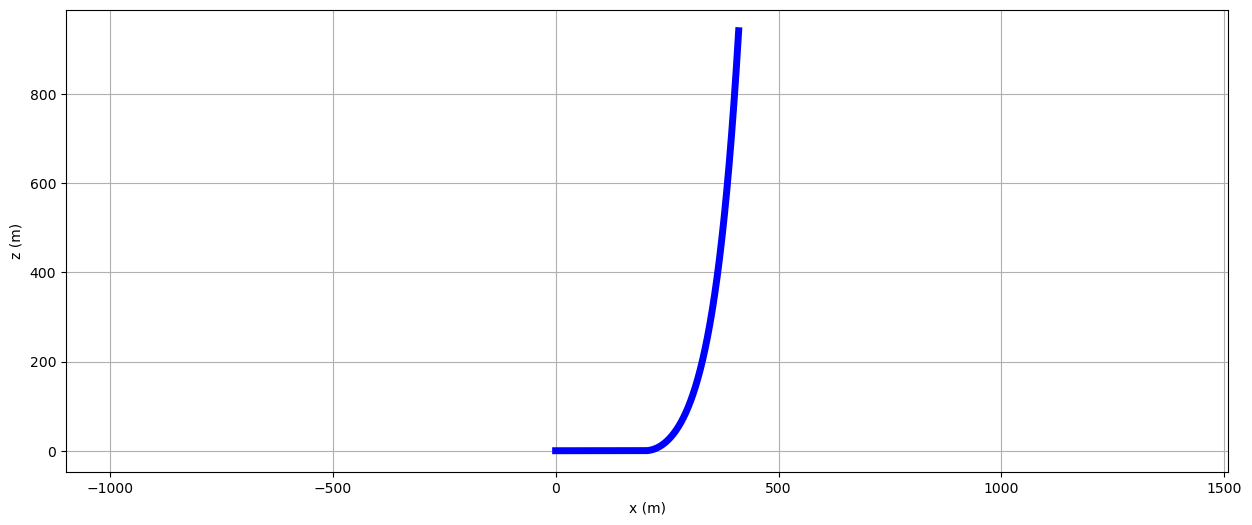

In [6]:
l2_s, l2_x, l2_z, l2_V = plot_catenary_xz(W_pm, L_tot, EA, V0, HEnd, L_susp, 0.1)

plt.plot(l2_x, l2_z, 'b-', lw=5)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
pass

## Solution for H0 and L_susp

- In the previous section we were solving for the end position of the fairlead (xEnd, zEnd), given the forces acting on the line and the suspended length of the line
- However, physically, we can easily measure the xEnd and zEnd, but its often difficult to measure the HEnd and L_susp.
- Therefore we need to do the inverse of the `catenary_end_xz()` function.
- Due to the nature of the catenary equation, it is not possible to directly invert the function
- Therefore, we will invert the function numerically, using an *iterative optimisation*.

The following cell solves for HEnd and L_Susp.
- Constants: W_pm, EA, L_Tot
- Input: xEnd, zEnd, V0
- Output: HEnd, L_susp

The *iterative* algorithm works as follows. Here (xEnd, zEnd) is the known end position of the fairlead.

1. Assume a guess value for HEnd, L_susp
2. Solve for xEnd, zEnd using `catenary_end_xz()` using this guess value of HEnd, L_susp. Lets call these xEnd_k, zEnd_k, where _k_ is the iteration number.
3. We are trying to enforce _(xEnd_k - xEnd)=0_ and _(yEnd_k - yEnd)=0_ (note, two eqns, two unknowns)
    - We enforce this by checking the error _abs(xEnd_k - xEnd)_ and _abs(yEnd_k - yEnd)_.
5. If the error tends to 0 then we have obtained the solution for HEnd and L_susp
6. If the error >> 0, then move onto the next iteration (k = k+1).
    - In iteration _k+1_ the guess values of HEnd and L_susp are updated based on the error.

Once we know the L_susp, we can also calculate the VEnd as the weight of the suspended portion of the line.

    - VEnd = L_susp x W_pm x g

In [7]:
def inv_catenary_end_xz(W_pm, L_tot, EA, V0, xEnd, zEnd):    

    def objective_fnc(sol, *data):        
        H0 = sol[0]
        L = sol[1] #suspended length
        W_pm, L_tot, EA, V0, xtarg, ztarg  = data
        x, z = catenary_end_xz(W_pm, L_tot, EA, V0, H0, L)
        
        return np.array( [abs(ztarg-z),  abs(xtarg-x)] )

    data = (W_pm, L_tot, EA, V0, xEnd, zEnd)
    HEnd, L_susp = optimize.fsolve(objective_fnc,np.array([10,10]),args=data)
    VEnd = L_susp * W_pm * g

    return HEnd, VEnd, L_susp

Lets test this *iterative* solution procedure.

We will prescribe the end positions of the fairlead as xEnd, zEnd = (450, 250) meter.

Using this we will solve for the inverse of `caternary_end_xz()` function as follows.

In [8]:
xEnd = 800
zEnd = 400

HEnd_calc, VEnd_calc, L_susp_calc = inv_catenary_end_xz(W_pm, L_tot, EA, V0, xEnd, zEnd)

print("Prescribed position of the fairlead was (xEnd, zEnd) =", f"{xEnd,.5}", f"{zEnd,.5}")
print("Calculated Horizontal Force ","HEnd ",f"{HEnd_calc/1000:.4}","kN ")
print("Calculated Vertical Force fairlead ","VEnd ",f"{VEnd_calc/1000:.5}","kN ")
print("Calculated Suspended length ","Ls ",f"{L_susp_calc:.4}","m ")

Prescribed position of the fairlead was (xEnd, zEnd) = (800, 0.5) (400, 0.5)
Calculated Horizontal Force  HEnd  0.01 kN 
Calculated Vertical Force fairlead  VEnd  17.658 kN 
Calculated Suspended length  Ls  10.0 m 


c:\Users\leuma\anaconda3\envs\mude\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


You can recheck this solution by passing the calculated solution for the (HEnd, L_susp) into a previous `catenary_end_xz()` function to confirm if the inverse was calculated correctly.

You can also plot this line using `plot_catenary_xz()`.

9.99999999999998 1190.0462652305353 9.994378561640852 17657.999999999967


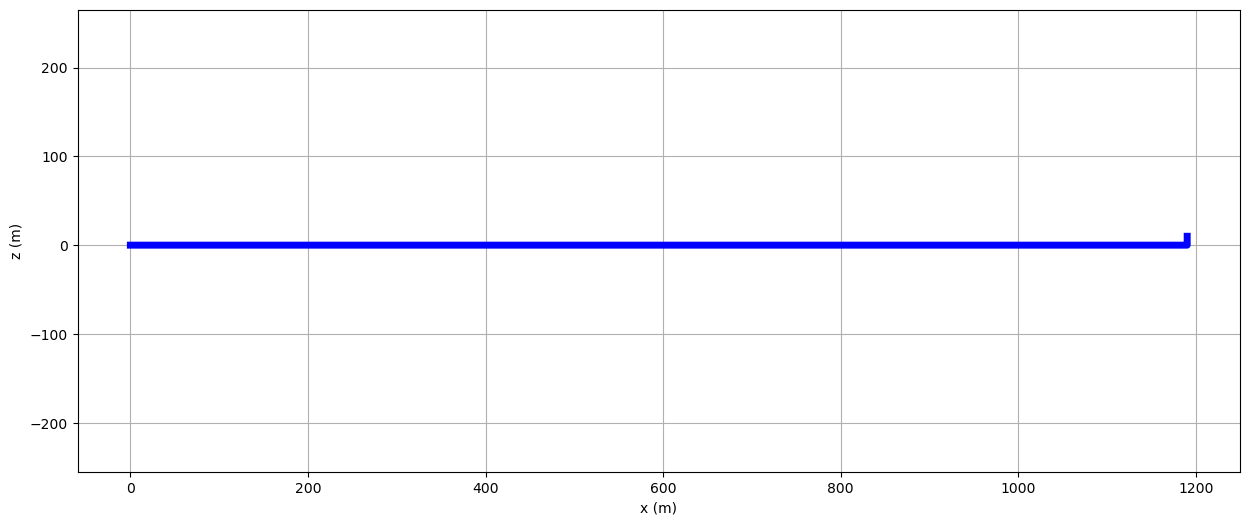

In [9]:
l2_s, l2_x, l2_z, l2_V = plot_catenary_xz(W_pm, L_tot, EA, V0, HEnd_calc, L_susp_calc, 0.1)

plt.plot(l2_x, l2_z, 'b-', lw=5)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
pass

So now we have the ability to calculate


`catenary_end_xz()`
- Constants: W_pm, EA, L_Tot
- Input: V0, HEnd or H0, L_susp
- Output: xEnd, zEnd

`inv_catenary_end_xz()`
- Constants: W_pm, EA, L_Tot
- Input: V0, xEnd, zEnd
- Output: HEnd, VEnd L_susp

## Trial Run

You can use the followinf cells to play with the code.
Here you can specify various fairlead position xEnd zEnd and observe how the HEnd, L_susp and the plot of the line change.

Prescribed position of the fairlead was (xEnd, zEnd) = 1040 400
Calculated Horizontal Force  HEnd  775.3 kN 
Calculated Vertical Force fairlead  VEnd  1266.3 kN 
Calculated Suspended length  Ls  713.6 m 
713.5507359405964 1040.000000000005 399.99999999999 1266287.8289715247


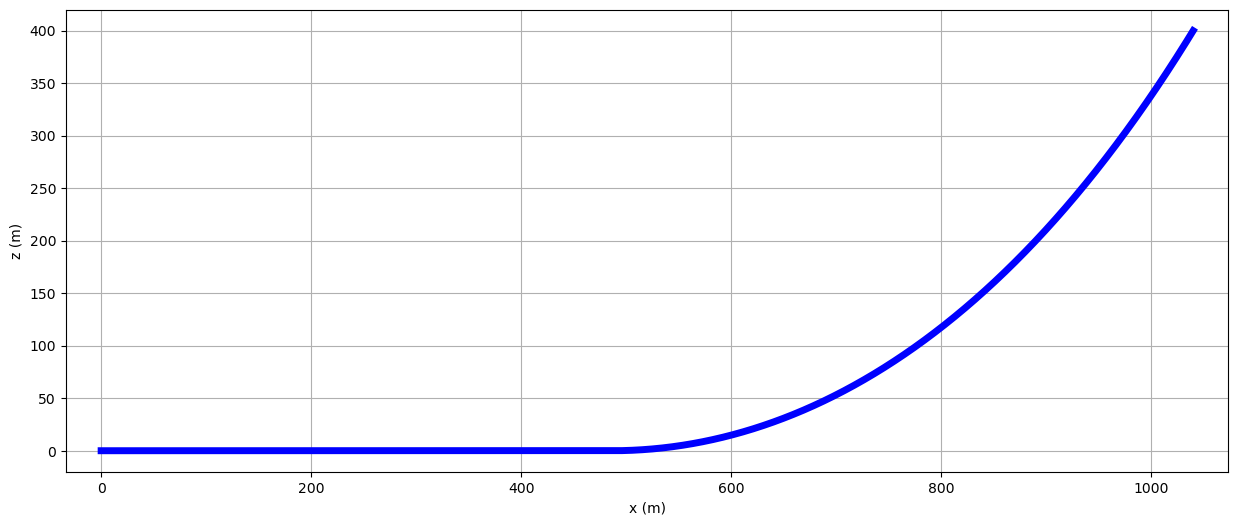

In [10]:
g = 9.81 #m/s2
W_pm = 180.9 #kg/m
EA = 2221000000 #N
L_tot = 1200 #m
V0 = 0

xEnd = 1040
zEnd = 400

HEnd_calc, VEnd_calc, L_susp_calc = inv_catenary_end_xz(W_pm, L_tot, EA, V0, xEnd, zEnd)

print("Prescribed position of the fairlead was (xEnd, zEnd) =", xEnd, zEnd)
print("Calculated Horizontal Force ","HEnd ",f"{HEnd_calc/1000:.4}","kN ")
print("Calculated Vertical Force fairlead ","VEnd ",f"{VEnd_calc/1000:.5}","kN ")
print("Calculated Suspended length ","Ls ",f"{L_susp_calc:.4}","m ")

l2_s, l2_x, l2_z, l2_V = plot_catenary_xz(W_pm, L_tot, EA, V0, HEnd_calc, L_susp_calc, 0.1)

plt.plot(l2_x, l2_z, 'b-', lw=5)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
pass

## Force-excursion diagram

- Consider a catenary line which has a total length (L_tot) = 600 m.
- We now evaluate the horizontal force (H0) for a range of xEnd.
- The plot of H0 vs xEnd is the force-excursion plot.
- Here the zEnd can be fixed as the still-water depth (d0) = 250m

[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195
 1196 

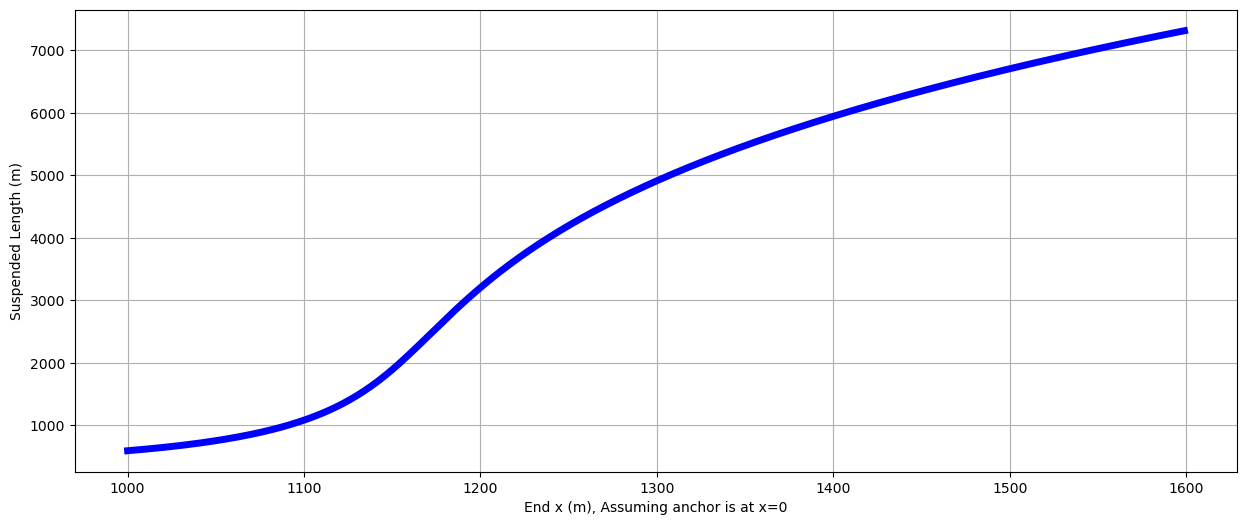

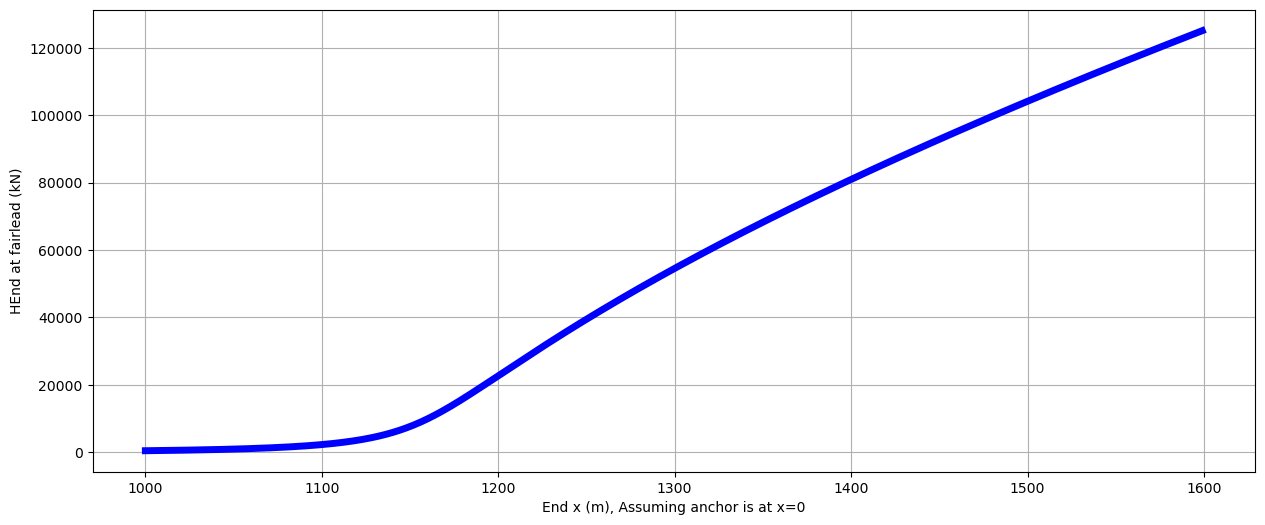

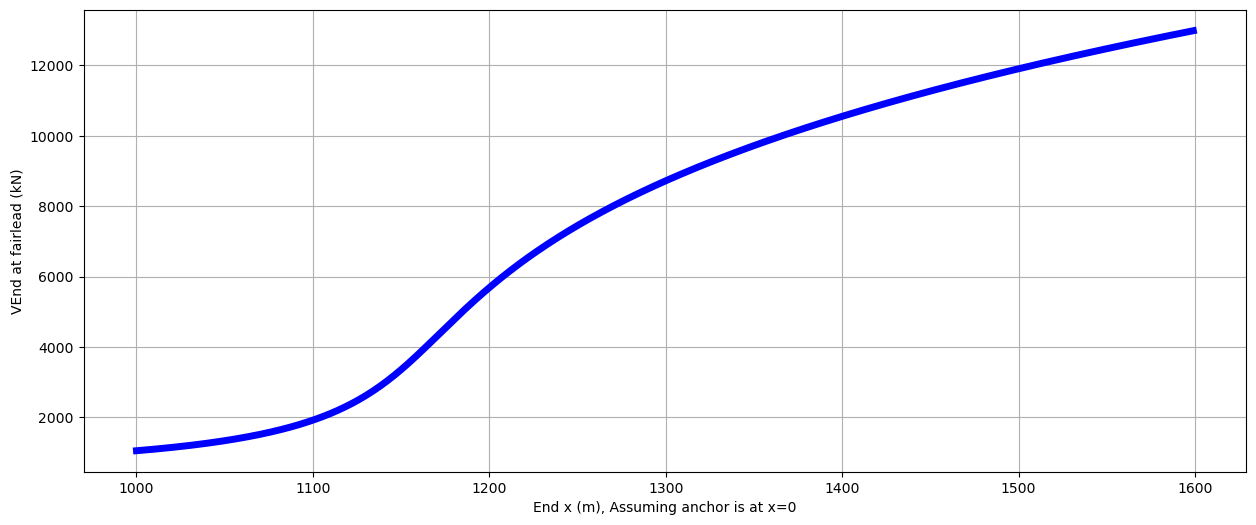

In [21]:
# Still-water depth (taken equal as fairlead position)
d0 = 400 #m

# Properties of the line
g = 9.81 #m/s2
W_pm = 180.9 #kg/m
EA = 2221000000 #N
L_tot = 1200 #m
V0 = 0

# Setting vertical position as water-depth 
zEnd = d0

#
# INPUT the target excursion: from 450 to 500 m
#
xEnd_array = np.arange(1000,1600)
print(xEnd_array)

sol_array = [inv_catenary_end_xz(W_pm, L_tot, EA, V0, lxEnd, zEnd) for lxEnd in xEnd_array]

sol = inv_catenary_end_xz(W_pm, L_tot, EA, V0, 1040, d0)
print('waarde',sol[0])

HEnd_array = [sol[0] for sol in sol_array]
VEnd_array = [sol[1] for sol in sol_array]
L_susp_array = [sol[2] for sol in sol_array]
# print(xEnd_array[1], H0_array[1]/1000)
# print(xEnd_array[-1], H0_array[-1]/1000)


plt.subplots(1,1)
plt.plot( xEnd_array, L_susp_array, 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('Suspended Length (m)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)


plt.subplots(1,1)
plt.plot( xEnd_array, [Hl/1000 for Hl in HEnd_array], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('HEnd at fairlead (kN)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)

plt.subplots(1,1)
plt.plot( xEnd_array, [Vstep/1000 for Vstep in VEnd_array], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('VEnd at fairlead (kN)')
pass

We can calculate the horizontal and vertical stiffness stiffness of the line by checking the slope of the force excursion diagram.

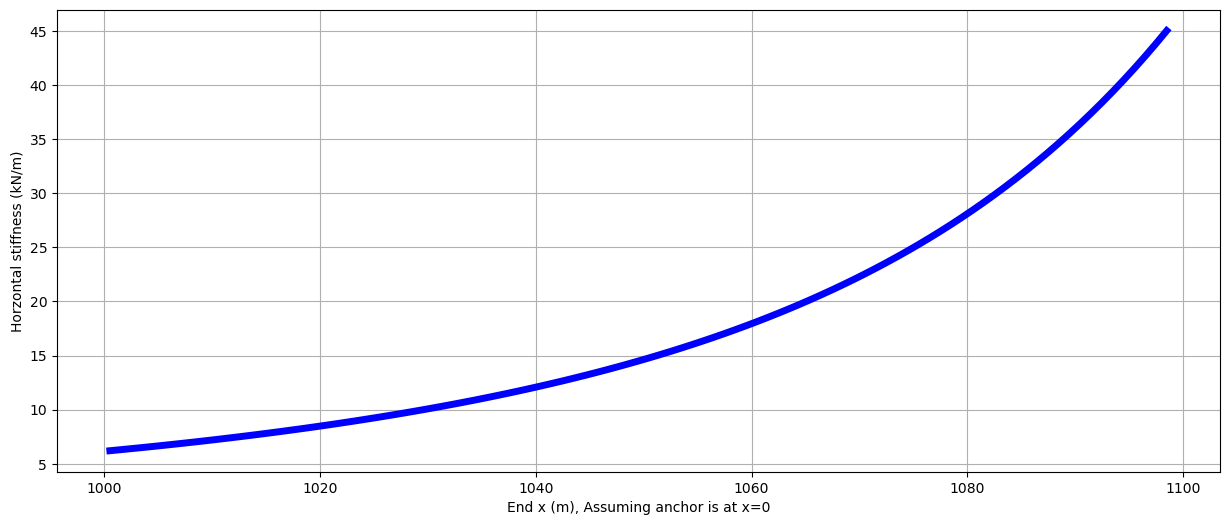

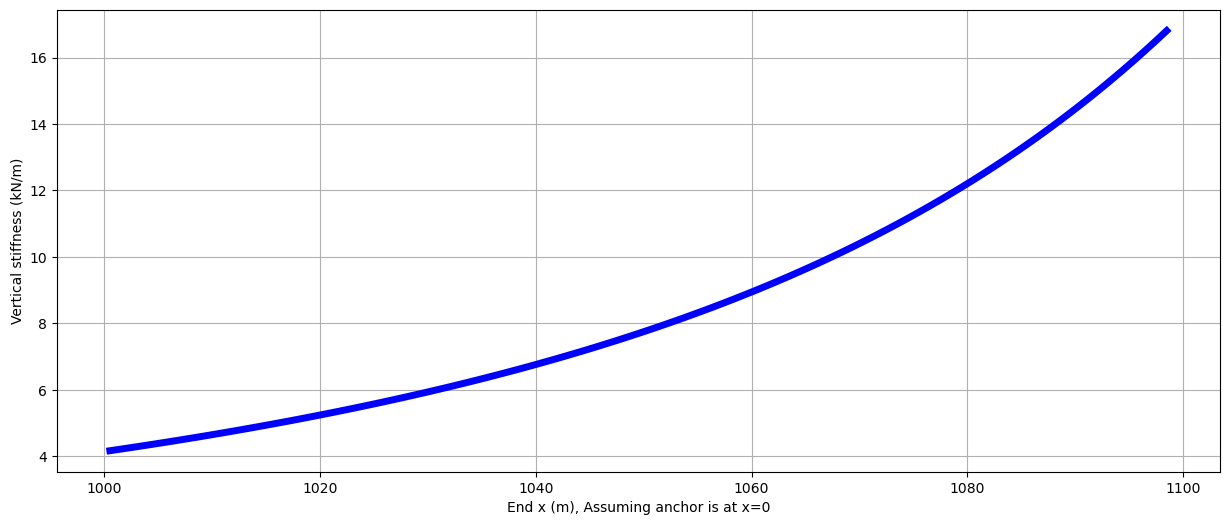

In [12]:
dx = xEnd_array[1]-xEnd_array[0]

# We evaluate the slope using the central difference method.
# dH/dx [i+1/2] = (H[i+1] - H[i])/dx
HEnd_slope = [ (l1-l2)/dx for (l1,l2) in zip(HEnd_array[1:], HEnd_array[0:-1])]
VEnd_slope = [ (l1-l2)/dx for (l1,l2) in zip(VEnd_array[1:], VEnd_array[0:-1])]
xEnd_array2 = [ lx+dx/2 for lx in xEnd_array[0:-1] ]

plt.subplots(1,1)
plt.plot( xEnd_array2, [Hl/1000 for Hl in HEnd_slope], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('Horzontal stiffness (kN/m)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)

plt.subplots(1,1)
plt.plot( xEnd_array2, [Vl/1000 for Vl in VEnd_slope], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('Vertical stiffness (kN/m)')

pass